In [65]:
import numpy as np
import matplotlib.pyplot as plt
from vamos import (
    optimize, OptimizeConfig, NSGAIIConfig,
    FeatureSelectionProblem,
    HyperparameterTuningProblem,
    WeldedBeamDesignProblem,
)

plt.style.use("ggplot")
print("Real-world problems loaded successfully!")

Real-world problems loaded successfully!


## 1. Feature Selection (Binary Encoding)

Select features to minimize classification error while using fewer features.

**Problem:**
- Variables: Binary mask (1 = use feature, 0 = ignore)
- Objectives: (1) validation error, (2) number of selected features
- Dataset: Breast cancer (30 features)

In [66]:
# Create feature selection problem
fs_problem = FeatureSelectionProblem(dataset="breast_cancer", test_size=0.3, random_state=42)

print(f"Problem: Feature Selection")
print(f"  Variables: {fs_problem.n_var} (binary feature mask)")
print(f"  Objectives: {fs_problem.n_obj}")
print(f"    - f1: Validation error (minimize)")
print(f"    - f2: Number of features (minimize)")
print(f"  Encoding: {fs_problem.encoding}")

Problem: Feature Selection
  Variables: 30 (binary feature mask)
  Objectives: 2
    - f1: Validation error (minimize)
    - f2: Number of features (minimize)
  Encoding: binary


In [67]:
# Configure NSGA-II for binary encoding
fs_config = (
    NSGAIIConfig()
    .pop_size(50)
    .crossover("uniform", prob=0.9)  # Uniform crossover for binary
    .mutation("bitflip", prob=0.05)  # Bit-flip mutation
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run optimization
fs_result = optimize(OptimizeConfig(
    problem=fs_problem,
    algorithm="nsgaii",
    algorithm_config=fs_config,
    termination=("n_eval", 3000),
    seed=42,
))

print(f"Found {len(fs_result.F)} Pareto-optimal feature subsets")

Found 27 Pareto-optimal feature subsets


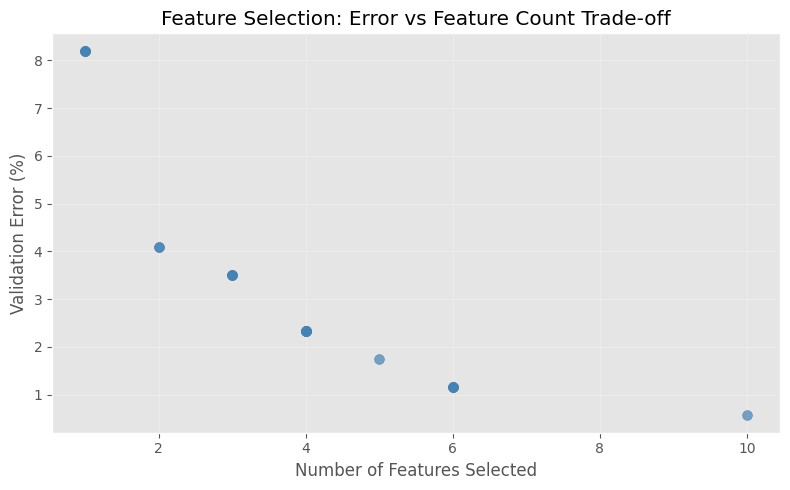

In [68]:
# Visualize trade-off: error vs number of features
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(fs_result.F[:, 1], fs_result.F[:, 0] * 100, s=50, alpha=0.7, c='steelblue')
ax.set_xlabel("Number of Features Selected")
ax.set_ylabel("Validation Error (%)")
ax.set_title("Feature Selection: Error vs Feature Count Trade-off")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
# Analyze specific solutions
print("Sample Pareto-optimal solutions:")
print("-" * 50)

# Sort by number of features
sorted_idx = np.argsort(fs_result.F[:, 1])

for i in [0, len(sorted_idx)//2, -1]:  # Few, medium, many features
    idx = sorted_idx[i]
    error = fs_result.F[idx, 0] * 100
    n_features = int(fs_result.F[idx, 1])
    mask = fs_result.X[idx] > 0.5
    selected_idx = np.where(mask)[0]
    
    print(f"Solution {i+1}: {n_features} features, {error:.2f}% error")
    print(f"  Features: {selected_idx[:10]}{'...' if len(selected_idx) > 10 else ''}")
    print()

Sample Pareto-optimal solutions:
--------------------------------------------------
Solution 1: 1 features, 8.19% error
  Features: [7]

Solution 14: 4 features, 2.34% error
  Features: [ 1  6 13 19]

Solution 0: 10 features, 0.58% error
  Features: [ 1  6  8  9 10 13 19 21 24 28]



## 2. Hyperparameter Tuning (Mixed Encoding)

Optimize SVM hyperparameters with mixed variable types.

**Problem:**
- Variables: C (real), gamma (real), kernel (categorical), degree (integer)
- Objectives: (1) validation error, (2) model complexity
- Encoding: Mixed (real + integer + categorical)

In [70]:
# Create hyperparameter tuning problem
hp_problem = HyperparameterTuningProblem(dataset="breast_cancer", test_size=0.3, random_state=42)

print(f"Problem: Hyperparameter Tuning")
print(f"  Variables: {hp_problem.n_var}")
print(f"    - x0: C regularization (log-scale, 1e-2 to 1e2)")
print(f"    - x1: gamma (log-scale, 1e-3 to 1e1)")
print(f"    - x2: kernel (rbf, linear, poly)")
print(f"    - x3: polynomial degree (2-5)")
print(f"  Objectives: {hp_problem.n_obj}")
print(f"  Encoding: {hp_problem.encoding}")

Problem: Hyperparameter Tuning
  Variables: 4
    - x0: C regularization (log-scale, 1e-2 to 1e2)
    - x1: gamma (log-scale, 1e-3 to 1e1)
    - x2: kernel (rbf, linear, poly)
    - x3: polynomial degree (2-5)
  Objectives: 2
  Encoding: mixed


In [71]:
# Configure NSGA-II for mixed encoding
hp_config = (
    NSGAIIConfig()
    .pop_size(50)
    .crossover("mixed", prob=0.9)  # Mixed crossover handles real/int/cat
    .mutation("mixed", prob=0.25)  # Mixed mutation per variable type
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run optimization
hp_result = optimize(OptimizeConfig(
    problem=hp_problem,
    algorithm="nsgaii",
    algorithm_config=hp_config,
    termination=("n_eval", 2000),
    seed=42,
))

print(f"Found {len(hp_result.F)} Pareto-optimal configurations")

Found 50 Pareto-optimal configurations


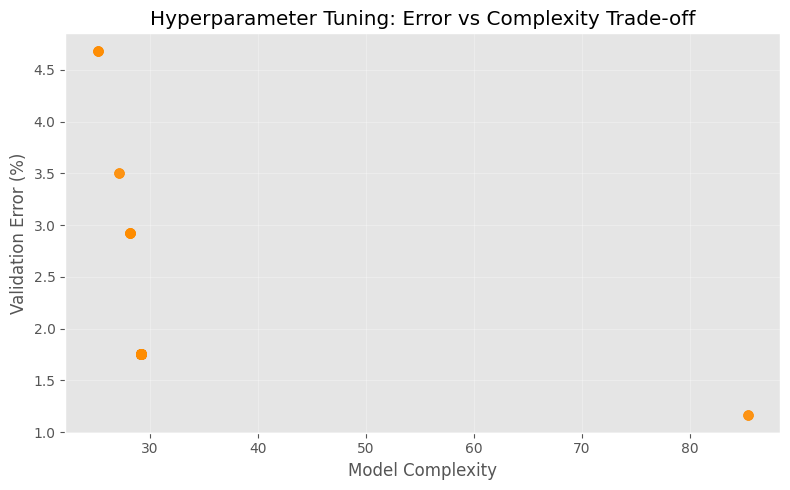

In [72]:
# Visualize trade-off: error vs complexity
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(hp_result.F[:, 1], hp_result.F[:, 0] * 100, s=50, alpha=0.7, c='darkorange')
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Validation Error (%)")
ax.set_title("Hyperparameter Tuning: Error vs Complexity Trade-off")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# Decode and show best configurations
kernels = ["rbf", "linear", "poly"]

print("Top 5 configurations (by error):")
print("-" * 60)

sorted_idx = np.argsort(hp_result.F[:, 0])[:5]
for rank, idx in enumerate(sorted_idx, 1):
    x = hp_result.X[idx]
    C = 10.0 ** (x[0] * 4.0 - 2.0)
    gamma = 10.0 ** (x[1] * 4.0 - 3.0)
    kernel = kernels[int(np.clip(np.round(x[2]), 0, 2))]
    degree = int(np.clip(np.round(x[3]), 2, 5))
    error = hp_result.F[idx, 0] * 100
    complexity = hp_result.F[idx, 1]
    
    print(f"#{rank}: Error={error:.2f}%, Complexity={complexity:.2f}")
    print(f"    C={C:.4f}, gamma={gamma:.6f}, kernel={kernel}, degree={degree}")
    print()

Top 5 configurations (by error):
------------------------------------------------------------
#1: Error=1.17%, Complexity=85.30
    C=2.7594, gamma=0.037157, kernel=rbf, degree=3

#2: Error=1.17%, Complexity=85.30
    C=2.7594, gamma=0.037157, kernel=rbf, degree=3

#3: Error=1.75%, Complexity=29.20
    C=1.1132, gamma=0.272688, kernel=linear, degree=2

#4: Error=1.75%, Complexity=29.20
    C=1.1072, gamma=0.592418, kernel=linear, degree=2

#5: Error=1.75%, Complexity=29.20
    C=1.1381, gamma=0.221713, kernel=linear, degree=2



## 3. Welded Beam Design (Constrained Optimization)

Engineering design with structural constraints.

**Problem:**
- Variables: h (weld thickness), l (length), t (flange thickness), b (width), material, stiffeners
- Objectives: (1) fabrication cost, (2) deflection
- Constraints: shear stress, normal stress, deflection limit, geometric

In [74]:
# Create engineering design problem
eng_problem = WeldedBeamDesignProblem()

print(f"Problem: Welded Beam Design")
print(f"  Variables: {eng_problem.n_var}")
print(f"    - h: weld thickness [0.125, 5]")
print(f"    - l: length [0.1, 10]")
print(f"    - t: flange thickness [0.1, 10]")
print(f"    - b: width [0.125, 5]")
print(f"    - material: {0, 1, 2} (categorical)")
print(f"    - stiffeners: [2, 6] (integer)")
print(f"  Objectives: {eng_problem.n_obj} (cost, deflection)")
print(f"  Constraints: 4 (stress limits, geometry)")
print(f"  Encoding: {eng_problem.encoding}")

Problem: Welded Beam Design
  Variables: 6
    - h: weld thickness [0.125, 5]
    - l: length [0.1, 10]
    - t: flange thickness [0.1, 10]
    - b: width [0.125, 5]
    - material: (0, 1, 2) (categorical)
    - stiffeners: [2, 6] (integer)
  Objectives: 2 (cost, deflection)
  Constraints: 4 (stress limits, geometry)
  Encoding: mixed


In [75]:
# Configure NSGA-II for constrained optimization
eng_config = (
    NSGAIIConfig()
    .pop_size(100)
    .crossover("mixed", prob=0.9)
    .mutation("mixed", prob=0.2)
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run optimization
eng_result = optimize(OptimizeConfig(
    problem=eng_problem,
    algorithm="nsgaii",
    algorithm_config=eng_config,
    termination=("n_eval", 5000),
    seed=42,
))

print(f"Found {len(eng_result.F)} solutions")

Found 100 solutions


In [76]:
# Check constraint satisfaction
G = eng_result.data.get("G")
if G is not None:
    feasible_mask = np.all(G <= 0, axis=1)
    n_feasible = np.sum(feasible_mask)
    print(f"Feasible solutions: {n_feasible} / {len(eng_result.F)}")
else:
    feasible_mask = np.ones(len(eng_result.F), dtype=bool)
    n_feasible = len(eng_result.F)

Feasible solutions: 100 / 100


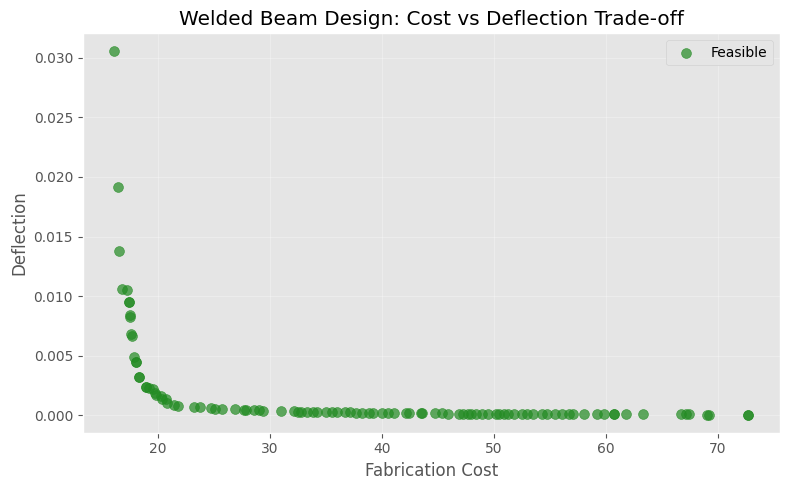

In [77]:
# Visualize trade-off: cost vs deflection
fig, ax = plt.subplots(figsize=(8, 5))

# Plot infeasible solutions in gray
if G is not None:
    infeasible_mask = ~feasible_mask
    if np.any(infeasible_mask):
        ax.scatter(eng_result.F[infeasible_mask, 0], eng_result.F[infeasible_mask, 1],
                   s=30, alpha=0.3, c='gray', label='Infeasible')

# Plot feasible solutions
if np.any(feasible_mask):
    ax.scatter(eng_result.F[feasible_mask, 0], eng_result.F[feasible_mask, 1],
               s=50, alpha=0.7, c='forestgreen', label='Feasible')

ax.set_xlabel("Fabrication Cost")
ax.set_ylabel("Deflection")
ax.set_title("Welded Beam Design: Cost vs Deflection Trade-off")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
# Show best feasible designs
if np.any(feasible_mask):
    feasible_F = eng_result.F[feasible_mask]
    feasible_X = eng_result.X[feasible_mask]
    
    # Sort by cost
    sorted_idx = np.argsort(feasible_F[:, 0])[:5]
    
    print("Top 5 feasible designs (by cost):")
    print("-" * 70)
    
    materials = ["Standard", "High-strength", "Premium"]
    for rank, idx in enumerate(sorted_idx, 1):
        x = feasible_X[idx]
        cost = feasible_F[idx, 0]
        deflection = feasible_F[idx, 1]
        
        h, l, t, b = x[0], x[1], x[2], x[3]
        material = materials[int(np.clip(np.round(x[4]), 0, 2))]
        stiffeners = int(np.clip(np.round(x[5]), 2, 6))
        
        print(f"#{rank}: Cost={cost:.2f}, Deflection={deflection:.4f}")
        print(f"    h={h:.3f}, l={l:.3f}, t={t:.3f}, b={b:.3f}")
        print(f"    Material: {material}, Stiffeners: {stiffeners}")
        print()
else:
    print("No feasible solutions found. Try increasing the budget.")

Top 5 feasible designs (by cost):
----------------------------------------------------------------------
#1: Cost=16.13, Deflection=0.0305
    h=0.629, l=4.237, t=2.355, b=2.756
    Material: Standard, Stiffeners: 2

#2: Cost=16.47, Deflection=0.0192
    h=0.614, l=3.594, t=2.827, b=2.532
    Material: Standard, Stiffeners: 2

#3: Cost=16.55, Deflection=0.0138
    h=0.648, l=2.910, t=3.265, b=2.293
    Material: Standard, Stiffeners: 2

#4: Cost=16.85, Deflection=0.0106
    h=0.323, l=3.152, t=3.558, b=2.292
    Material: Standard, Stiffeners: 2

#5: Cost=17.29, Deflection=0.0105
    h=0.639, l=3.486, t=3.581, b=2.269
    Material: Standard, Stiffeners: 2



## 4. Compare All Problems

Side-by-side visualization of Pareto fronts:

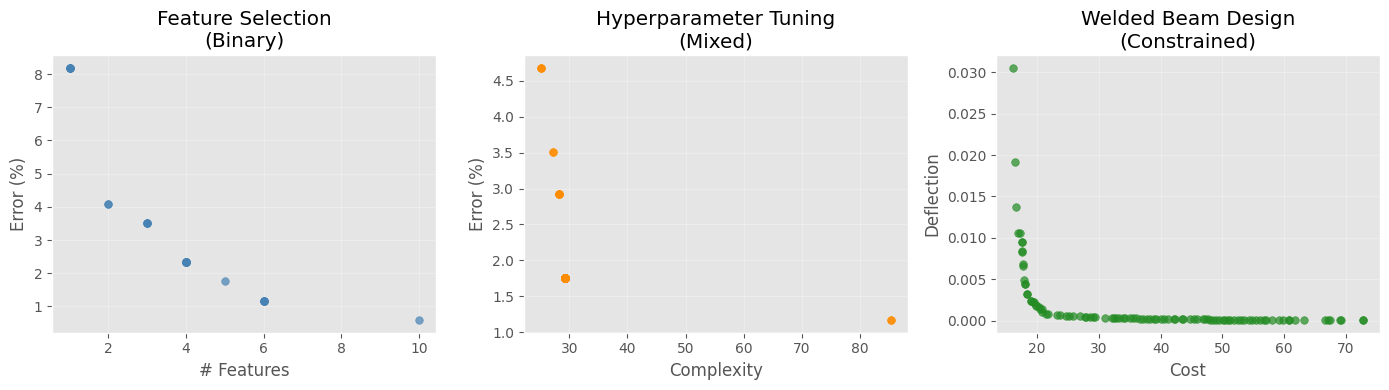

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Feature Selection
axes[0].scatter(fs_result.F[:, 1], fs_result.F[:, 0] * 100, s=30, alpha=0.7, c='steelblue')
axes[0].set_xlabel("# Features")
axes[0].set_ylabel("Error (%)")
axes[0].set_title("Feature Selection\n(Binary)")
axes[0].grid(True, alpha=0.3)

# Hyperparameter Tuning
axes[1].scatter(hp_result.F[:, 1], hp_result.F[:, 0] * 100, s=30, alpha=0.7, c='darkorange')
axes[1].set_xlabel("Complexity")
axes[1].set_ylabel("Error (%)")
axes[1].set_title("Hyperparameter Tuning\n(Mixed)")
axes[1].grid(True, alpha=0.3)

# Engineering Design
if np.any(feasible_mask):
    axes[2].scatter(eng_result.F[feasible_mask, 0], eng_result.F[feasible_mask, 1],
                    s=30, alpha=0.7, c='forestgreen')
axes[2].set_xlabel("Cost")
axes[2].set_ylabel("Deflection")
axes[2].set_title("Welded Beam Design\n(Constrained)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

VAMOS handles diverse real-world problems:

| Problem | Encoding | Objectives | Constraints |
|---------|----------|------------|-------------|
| Feature Selection | Binary | Error, # features | None |
| Hyperparameter Tuning | Mixed (real + int + categorical) | Error, complexity | None |
| Welded Beam Design | Mixed + constrained | Cost, deflection | 4 stress/geometry |

**Key points:**
- Use appropriate operators for each encoding (uniform/bitflip for binary, SBX/PM for real/mixed)
- Constraints are handled automatically (feasibility-first ranking)
- Mixed problems work with standard operators + repair
- Real-world problems require `scikit-learn` (install with `pip install vamos[examples]`)